# CNNs for Face Identification

This notebook implements face identification using a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class calssification problem where we have training/testing images for a set of subjects (classes).

The approach involves comparing the performance of a traditional[Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) method with that of a Convolutional Neural Network (CNN) model.



In [ ]:
import sys
print(sys.version)

3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]


## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
np.random.seed(42)
tf.random.set_seed(42)

## Loading the LFW dataset

In [ ]:
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

## Data Preprocessing

In [ ]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 62
Number of images: 3023

data_x shape: (3023, 62, 47, 1)
data_y shape: (3023,)


## Sample Dataset Grayscale Images

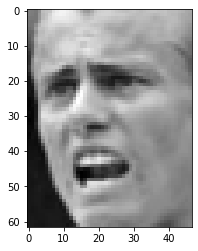

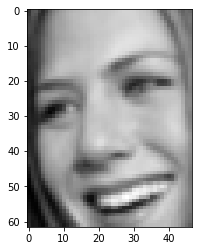

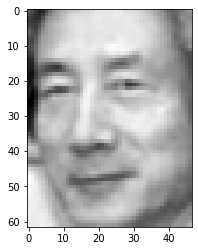

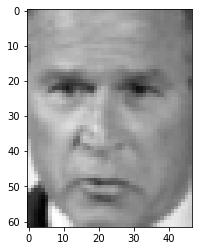

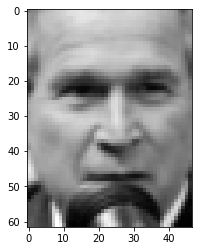

In [ ]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

## Dataset Split 90:10

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (2720, 62, 47, 1)
train_y shape: (2720,)

test_x shape: (303, 62, 47, 1)
test_y shape: (303,)


### Eigenfaces Overview
Eigenfaces is a Principal Component Analysis (PCA)-based dimensionality reduction technique used for face identification. It extracts features from facial images and reduces the dimensionality of the dataset.

In [ ]:
# flatten images
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (2720, 2914)
Eigenfaces shape: (173, 2914)


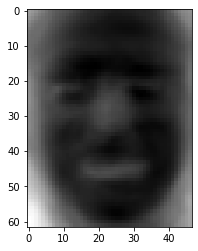

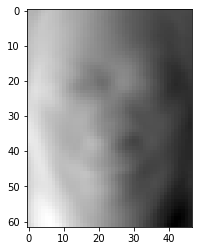

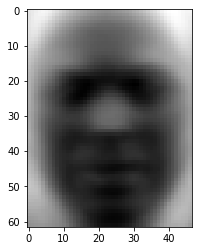

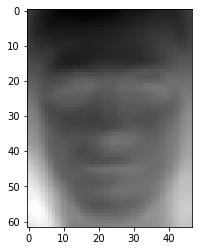

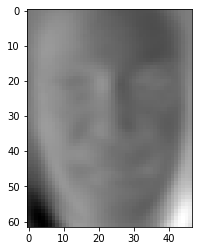

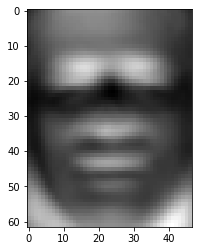

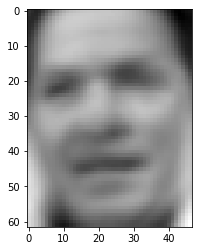

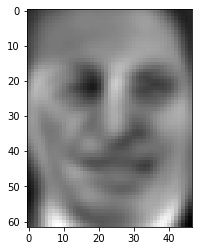

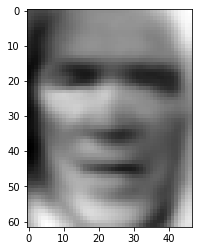

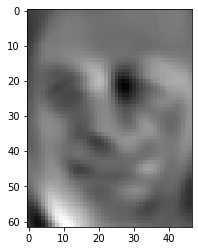

In [ ]:
# Displaying the first 10 Eigenfaces
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

In [ ]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (2720, 2914)
Training features shape: (2720, 173)
Testing vectors shape: (303, 2914)
Testing features shape: (303, 173)


## Eigenfaces and Logistic Regression Model

In [ ]:
features = Input((train_features_x.shape[1],))
x = Dense(num_subjects)(features)
predictions = Activation("softmax")(x)

logistic_regression = Model(inputs=features, outputs=predictions)

logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])
print(logistic_regression.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 173)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 62)                10788     
_________________________________________________________________
activation_2 (Activation)    (None, 62)                0         
Total params: 10,788
Trainable params: 10,788
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_y), y= train_y)
class_weights_list =dict(enumerate(class_weights))
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y),
                        class_weight=class_weights_list,
                        epochs=100, batch_size=128, verbose=0)
# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)
print("\nTraining accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

c:\users\tijoseph\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61], y=[18 53  6 ... 35 26 39] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)



Training accuracy using Eigenfaces and logistic regression model: 0.8849264705882353
Testing accuracy using Eigenfaces and logistic regression model: 0.6105610561056105


# CNN Models
The Eigenfaces and logistic regression model doesn't perform that well on the unseen test set.
Hence, the CNN performs both feature extraction and multi-class classification.


## CNN Model 1

In [ ]:
# Define Model 1
model1 = tf.keras.Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], 1)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_subjects, activation='softmax')
])
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 62, 47, 64)        640       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 23, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 31, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 11, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 15, 11, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 10560)           

In [ ]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model1.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weights,
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model1.predict(train_x), axis=1)
test_pred = np.argmax(model1.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model 1: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model 1: {}\n".format(accuracy_score(test_y, test_pred)))


c:\users\tijoseph\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61], y=[18 53  6 ... 35 26 39] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 2720 samples, validate on 303 samples
Epoch 1/15
2720/2720 [==============================] - 8s 3ms/sample - loss: 3.7822 - accuracy: 0.1754 - val_loss: 3.7152 - val_accuracy: 0.1485
Epoch 2/15
2720/2720 [==============================] - 7s 3ms/sample - loss: 3.7061 - accuracy: 0.1787 - val_loss: 3.7864 - val_accuracy: 0.1485
Epoch 3/15
2720/2720 [==============================] - 8s 3ms/sample - loss: 3.5500 - accuracy: 0.1842 - val_loss: 3.4506 - val_accuracy: 0.1683
Epoch 4/15
2720/2720 [==============================] - 8s 3ms/sample - loss: 3.2806 - accuracy: 0.2224 - val_loss: 3.0779 - val_accuracy: 0.2409
Epoch 5/15
2720/2720 [==============================] - 8s 3ms/sample - loss: 2.9351 - accuracy: 0.2857 - val_loss: 2.7524 - val_accuracy: 0.3333
Epoch 6/15
2720/2720 [==============================] - 8s 3ms/sample - loss: 2.6295 - accuracy: 0.3382 - val_loss: 2.5118 - val_accuracy: 0.4125
Epoch 7/15
2720/2720 [==============================] - 8s 3ms/sample - loss:

## CNN Model 2

In [ ]:
# Define Model 2
model2 = tf.keras.Sequential([
    Conv2D(64, (9,9), padding='same', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], 1)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, (5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_subjects, activation='softmax')
])

# Compile Model 2
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 47, 64)        5248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 23, 128)       204928    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 11, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 21120)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 21120)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)              

In [ ]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model2.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weights,
               epochs=20, batch_size=128, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model2.predict(train_x), axis=1)
test_pred = np.argmax(model2.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model 2: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model 2: {}\n".format(accuracy_score(test_y, test_pred)))

c:\users\tijoseph\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61], y=[18 53  6 ... 35 26 39] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 2720 samples, validate on 303 samples
Epoch 1/20
2720/2720 [==============================] - 17s 6ms/sample - loss: 4.6919 - accuracy: 0.1320 - val_loss: 3.7369 - val_accuracy: 0.1485
Epoch 2/20
2720/2720 [==============================] - 16s 6ms/sample - loss: 3.7704 - accuracy: 0.1768 - val_loss: 3.9506 - val_accuracy: 0.1485
Epoch 3/20
2720/2720 [==============================] - 16s 6ms/sample - loss: 3.7745 - accuracy: 0.1735 - val_loss: 3.6903 - val_accuracy: 0.1485
Epoch 4/20
2720/2720 [==============================] - 17s 6ms/sample - loss: 3.7818 - accuracy: 0.1592 - val_loss: 3.7935 - val_accuracy: 0.1485
Epoch 5/20
2720/2720 [==============================] - 16s 6ms/sample - loss: 3.7604 - accuracy: 0.1816 - val_loss: 3.5439 - val_accuracy: 0.1518
Epoch 6/20
2720/2720 [==============================] - 18s 7ms/sample - loss: 3.5112 - accuracy: 0.1993 - val_loss: 3.4424 - val_accuracy: 0.1914
Epoch 7/20
2720/2720 [==============================] - 18s 7ms/sample 

## CNN Model 3

In [ ]:
# Define Model 3
model3 = tf.keras.Sequential([
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], 1)),
    Conv2D(64, (3, 3),padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3),padding='same', activation='relu'),
    Conv2D(128, (3, 3),padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_subjects, activation='softmax')
])

# Compile Model 3
model3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 62, 47, 64)        640       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 62, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 31, 23, 128)       73856     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 31, 23, 128)       147584    
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 15, 11, 128)       0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 21120)           

In [ ]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model3.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weights,
               epochs=10, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model3.predict(train_x), axis=1)
test_pred = np.argmax(model3.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model 3: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model 3: {}\n".format(accuracy_score(test_y, test_pred)))


c:\users\tijoseph\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61], y=[18 53  6 ... 35 26 39] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 2720 samples, validate on 303 samples
Epoch 1/10
2720/2720 [==============================] - 27s 10ms/sample - loss: 3.7958 - accuracy: 0.1662 - val_loss: 3.7668 - val_accuracy: 0.1485
Epoch 2/10
2720/2720 [==============================] - 27s 10ms/sample - loss: 3.6945 - accuracy: 0.1787 - val_loss: 3.4820 - val_accuracy: 0.1551
Epoch 3/10
2720/2720 [==============================] - 28s 10ms/sample - loss: 3.3808 - accuracy: 0.2022 - val_loss: 3.1390 - val_accuracy: 0.2376
Epoch 4/10
2720/2720 [==============================] - 27s 10ms/sample - loss: 2.8955 - accuracy: 0.3007 - val_loss: 2.5964 - val_accuracy: 0.3531
Epoch 5/10
2720/2720 [==============================] - 29s 11ms/sample - loss: 2.4256 - accuracy: 0.3930 - val_loss: 2.1725 - val_accuracy: 0.4785
Epoch 6/10
2720/2720 [==============================] - 27s 10ms/sample - loss: 2.0229 - accuracy: 0.4860 - val_loss: 1.8216 - val_accuracy: 0.5512
Epoch 7/10
2720/2720 [==============================] - 27s 10ms/

## CNN model 4

In [ ]:
# Define Model 4
model4 = tf.keras.Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], 1)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_subjects, activation='softmax')
])

# Compile Model 4
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 62, 47, 32)        320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 31, 23, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 31, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 15, 11, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 15, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 5, 128)         0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 7, 5, 128)       

In [ ]:
# since the subjects have different numbers of images,
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)

# train model
model4.fit(train_x, train_y, validation_data=(test_x, test_y),
               class_weight=class_weights,
               epochs=20, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(model4.predict(train_x), axis=1)
test_pred = np.argmax(model4.predict(test_x), axis=1)
print("\nTraining accuracy using CNN model 4: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using CNN model 4: {}\n".format(accuracy_score(test_y, test_pred)))


c:\users\tijoseph\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61], y=[18 53  6 ... 35 26 39] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 2720 samples, validate on 303 samples
Epoch 1/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 3.8094 - accuracy: 0.1636 - val_loss: 3.7105 - val_accuracy: 0.1485
Epoch 2/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 3.7220 - accuracy: 0.1779 - val_loss: 3.6947 - val_accuracy: 0.1485
Epoch 3/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 3.6791 - accuracy: 0.1783 - val_loss: 3.6020 - val_accuracy: 0.1485
Epoch 4/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 3.5089 - accuracy: 0.1831 - val_loss: 3.3079 - val_accuracy: 0.1947
Epoch 5/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 3.2218 - accuracy: 0.2283 - val_loss: 3.0328 - val_accuracy: 0.2739
Epoch 6/20
2720/2720 [==============================] - 5s 2ms/sample - loss: 2.9547 - accuracy: 0.2618 - val_loss: 2.7122 - val_accuracy: 0.3333
Epoch 7/20
2720/2720 [==============================] - 5s 2ms/sample - loss:

### Display Correctly Identified Image and Corresponding Training Image

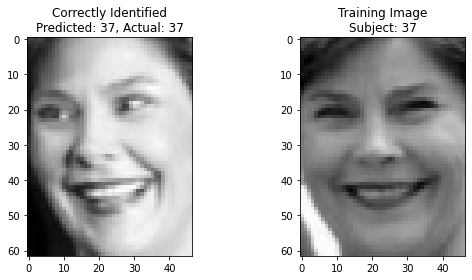

In [ ]:
predictions = model4.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)
correct_indices = np.where(predicted_classes == test_y)[0]
correct_index = correct_indices[0]
correct_predicted_class = predicted_classes[correct_index]
correct_actual_class = test_y[correct_index]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[correct_index, :, :, 0], cmap='gray')
plt.title(f'Correctly Identified\nPredicted: {correct_predicted_class}, Actual: {correct_actual_class}')
correct_train_index = np.where(train_y == correct_actual_class)[0][0]
plt.subplot(1, 2, 2)
plt.imshow(train_x[correct_train_index, :, :, 0], cmap='gray')
plt.title(f'Training Image\nSubject: {correct_actual_class}')
plt.tight_layout()
plt.show()

### Display Incorrectly Identified Image and Corresponding Training Image

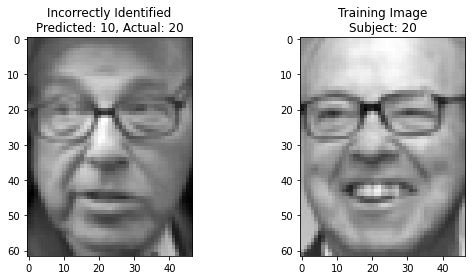

In [ ]:
incorrect_indices = np.where(predicted_classes != test_y)[0]
incorrect_index = incorrect_indices[0]
incorrect_predicted_class = predicted_classes[incorrect_index]
incorrect_actual_class = test_y[incorrect_index]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_x[incorrect_index, :, :, 0], cmap='gray')
plt.title(f'Incorrectly Identified\nPredicted: {incorrect_predicted_class}, Actual: {incorrect_actual_class}')
incorrect_train_index = np.where(train_y == incorrect_actual_class)[0][0]
plt.subplot(1, 2, 2)
plt.imshow(train_x[incorrect_train_index, :, :, 0], cmap='gray')
plt.title(f'Training Image\nSubject: {incorrect_actual_class}')
plt.tight_layout()
plt.show()